In [8]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm.auto import tqdm
import random
from collections import deque

In [5]:
# Frozen lake environment
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False, render_mode='human')
actions = env.action_space.n
states = env.observation_space.n

states, actions

(16, 4)

## Why use 2 networks?

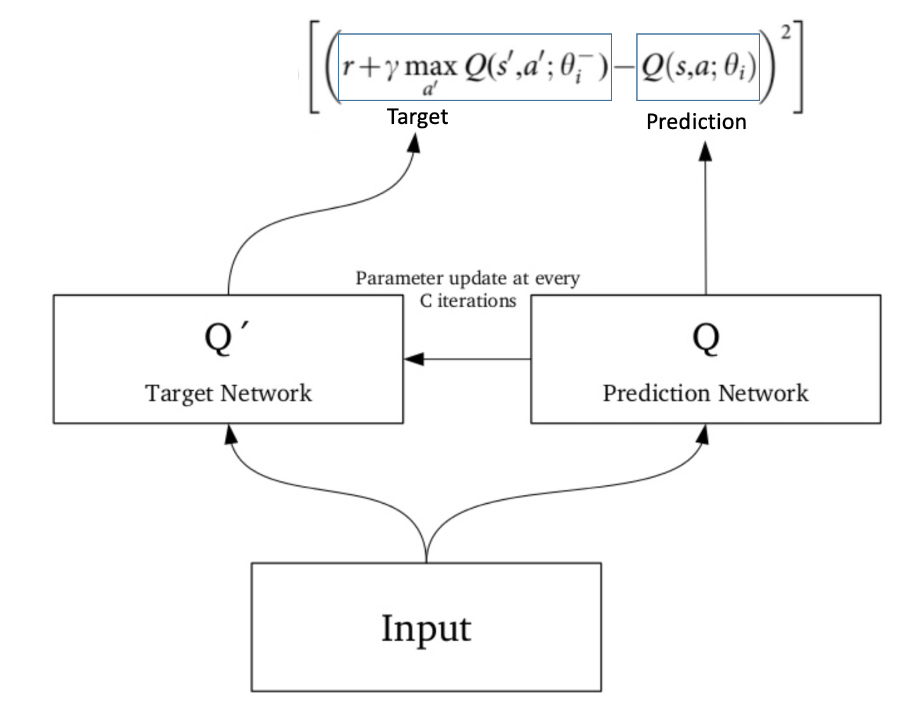

--------------------------------------------------------------------------------
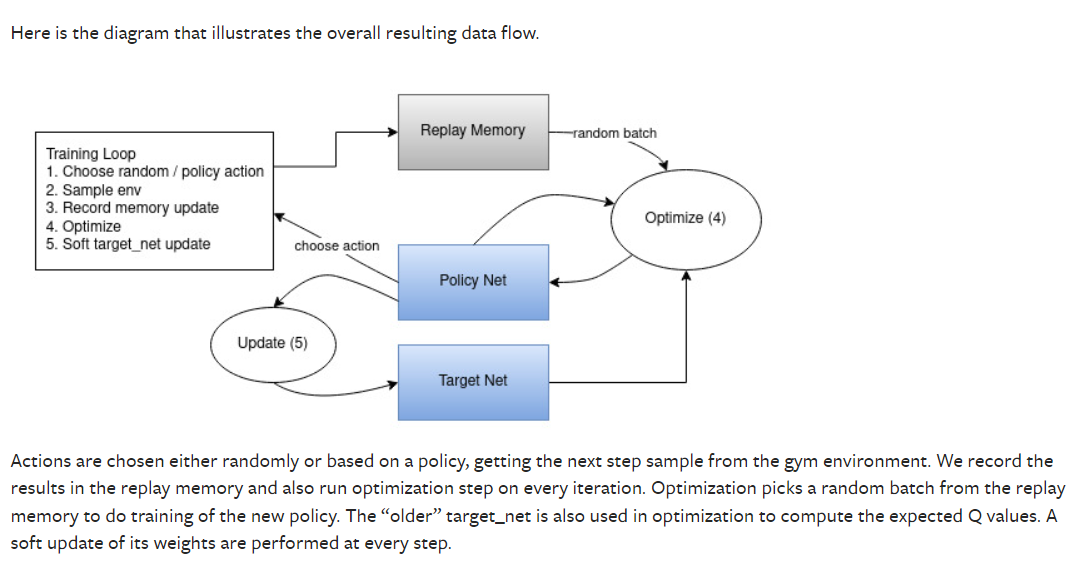


In [44]:
import torch
from torch import nn
import torch.nn.functional as F

In [55]:
class DQN(nn.Module):
    def __init__(self, in_states, hidden_nodes, out_actions):
        super(DQN, self).__init__()

        self.fc1 = nn.Linear(in_states, hidden_nodes)
        self.fc2 = nn.Linear(hidden_nodes, hidden_nodes)
        self.fc3 = nn.Linear(hidden_nodes, out_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [56]:
class ReplayMemory():
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def append(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [57]:
# Setting up Hyperparameters
learning_rate = 0.001           # Alpha    
discount_factor = 0.9           # Gamma
network_sync_rate = 10          # Number of steps before updating the target network with the policy network
replay_memory_capacity = 1000   # Number of transitions to store in the replay memory
batch_size = 32                 # Number of samples to take from the replay memory
epsilon = 1                     # Epsilon greedy policy
epsilon_decay = 0.001           # Decay rate of epsilon

# Replay memory
memory = ReplayMemory(replay_memory_capacity)

In [58]:
# Policy and target networks
actions = env.action_space.n
states = env.observation_space.n

policy_net = DQN(in_states=states, hidden_nodes=states, out_actions=actions)
target_net = DQN(in_states=states, hidden_nodes=states, out_actions=actions)

# Copy weights from policy net to target net
target_net.load_state_dict(policy_net.state_dict())
print("Policy and target networks are initialized and weights are copied.")
print(f"Policy (before, should be random): {policy_net}")

Policy and target networks are initialized and weights are copied.
Policy (before, should be random): DQN(
  (fc1): Linear(in_features=16, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=4, bias=True)
)


In [59]:
# Loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(policy_net.parameters(), lr=learning_rate)

In [60]:
def one_hot(state, num_states):
    input_tensor = torch.zeros(num_states)
    input_tensor[state] = 1
    return input_tensor

In [61]:
def optimize(batch, policy_net, target_net):
    num_states = policy_net.fc1.in_features

    current_q_list = []
    target_q_list = []

    for state, action, reward, next_state, terminated in batch:
        if terminated:
            # This means the episode ended after this transition. So the Q value is just the reward.
            # The agent either reached the goal or fell into a hole.
            target = torch.tensor(reward)
        else:
            # The Q value is the reward + discounted future Q value.
            with torch.no_grad():
                target = torch.tensor(
                    reward + discount_factor * target_net(one_hot(next_state, num_states=states)).max()
                )

        # Current set of q_values
        current_q = policy_net(one_hot(state, num_states=states))
        current_q_list.append(current_q)

        # Target set of q_values
        target_q = target_net(one_hot(state, num_states=states))
        target_q[action] = target
        target_q_list.append(target_q)

    # Compute the loss for the batch
    current_q_values = torch.stack(current_q_list)
    target_q_values = torch.stack(target_q_list)
    loss = loss_fn(current_q_values, target_q_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [70]:
def print_net(net):
    num_states = net.fc1.in_features

    for s in range(num_states):
        q_values = ''
        for q in net(one_hot(s, num_states)).tolist():
            q_values += "{:+.2f}".format(q) + ' '
        q_values = q_values.rstrip()

        ACTIONS = ['L', 'D', 'R', 'U']
        best_action = ACTIONS[net(one_hot(s, num_states)).argmax().item()]

        print(f'{s:02}, {best_action}, [{q_values}]', end='')
        if (s + 1) % 4 == 0:
            print()

In [71]:
print("Policy (before):")
print_net(policy_net)

Policy (before):
00, D, [+0.51 +0.59 +0.59 +0.55]01, R, [+0.55 +0.04 +0.65 +0.59]02, D, [+0.59 +0.73 +0.60 +0.66]03, L, [+0.65 +0.03 +0.45 +0.57]
04, D, [+0.58 +0.65 -0.00 +0.59]05, D, [+0.59 +0.73 +0.50 +0.43]06, D, [+0.10 +0.81 +0.10 +0.52]07, R, [+0.52 +0.70 +0.78 +0.52]
08, R, [+0.65 -0.01 +0.73 +0.61]09, D, [+0.68 +0.81 +0.80 +0.06]10, D, [+0.72 +0.90 -0.01 +0.62]11, U, [+0.42 +0.56 +0.49 +0.63]
12, L, [+0.55 +0.54 +0.49 +0.36]13, R, [+0.21 +0.82 +0.90 +0.73]14, R, [+0.79 +0.89 +1.00 +0.79]15, L, [+0.64 +0.59 +0.59 +0.54]


  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\Tejasv Kaushik\AppData\Local\Temp\ipykernel_14284\2737105070.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


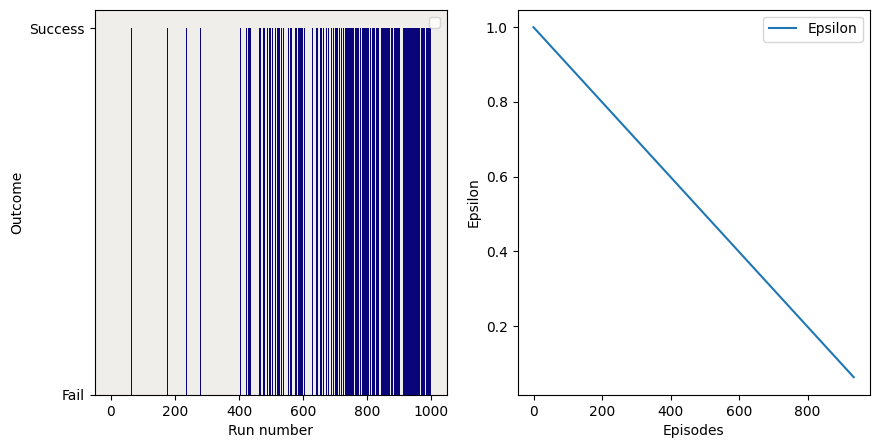

<Figure size 640x480 with 0 Axes>

In [64]:
episodes = 1000
rewards_per_episode = np.zeros(episodes)
epsilon_values = []
steps = 0
outcomes = []

# Training loop
for episode in tqdm(range(episodes)):
    state = env.reset()[0]
    terminated = False
    truncated = False

    outcomes.append("Fail")

    while(not terminated and not truncated):
        random_number = np.random.rand()

        # Epsilon greedy policy
        if random_number < epsilon:
            action = env.action_space.sample()                                              # Random action
        else:
            with torch.no_grad():
                action = torch.argmax(policy_net(one_hot(state, num_states=states))).item()  # Best action according to the policy network

        # Take action
        next_state, reward, terminated, truncated, _ = env.step(action)

        # Saving into replay memory for experience relay
        memory.append((state, action, reward, next_state, terminated))

        # Update state
        state = next_state
        steps += 1

    if reward == 1:
        rewards_per_episode[episode] = 1

    if reward:
        outcomes[-1] = "Success"

    # Sample from replay memory
    if len(memory) > batch_size and np.sum(rewards_per_episode) > 0:
        batch = memory.sample(batch_size)
        optimize(batch, policy_net, target_net)

        # Decay epsilon
        epsilon = max(epsilon - epsilon_decay, 0)
        epsilon_values.append(epsilon)

        # Sync target network with policy network after every network_sync_rate steps
        if steps > network_sync_rate:
            target_net.load_state_dict(policy_net.state_dict())
            # Reset steps
            steps = 0
    
# Plotting the rewards
plt.figure(figsize=(10, 5))
sum_rewards = np.cumsum(rewards_per_episode)
plt.subplot(1, 2, 1)
plt.xlabel("Run number")
plt.ylabel("Outcome")
ax = plt.gca()
ax.set_facecolor('#efeeea')
plt.bar(range(len(outcomes)), outcomes, color="#0A047A", width=1.0)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epsilon_values, label='Epsilon')
plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.legend()
plt.show()
plt.savefig('frozen_lake.png')
 

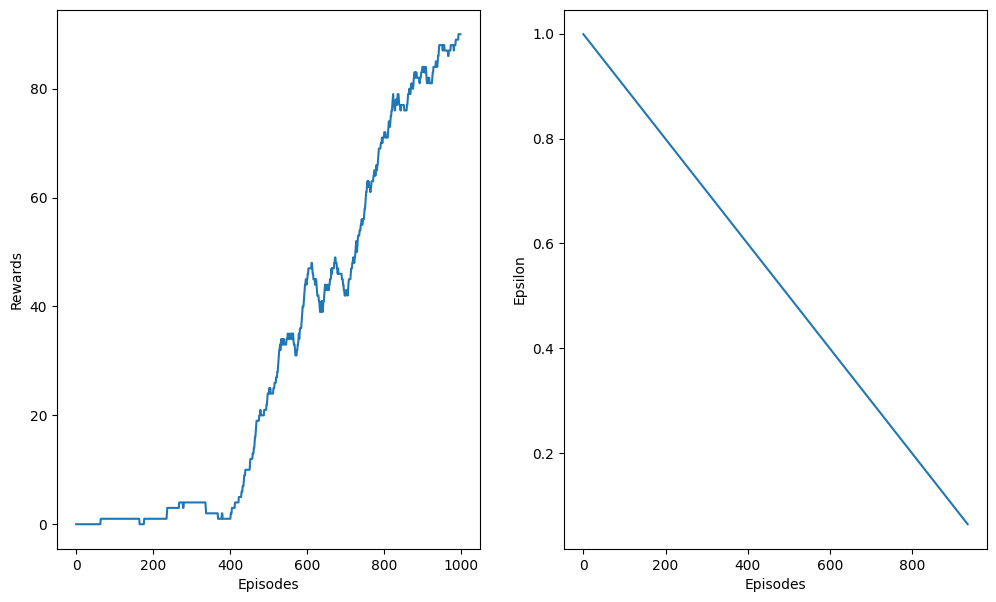

In [66]:
sum_rewards_train = np.zeros(episodes)
for x in range(episodes):
    sum_rewards_train[x] = np.sum(rewards_per_episode[max(0, x-100):(x+1)])

plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.plot(sum_rewards_train, label='Rewards')
plt.xlabel('Episodes')
plt.ylabel('Rewards')

plt.subplot(1, 2, 2)
plt.plot(epsilon_values, label='Epsilon')
plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.show()

In [68]:
# Testing the agent
test_episodes = 100
success = 0

policy_net.eval()

print("Policy (after training):", policy_net)

for episode in tqdm(range(test_episodes)):
    state = env.reset()[0]
    terminated = False
    truncated = False

    while(not terminated and not truncated):
        with torch.no_grad():
            action = torch.argmax(policy_net(one_hot(state, num_states=states))).item()

        # Take action
        next_state, reward, terminated, truncated, _ = env.step(action)

        state = next_state

    if reward == 1:
        success += 1

print(f"Success rate: {success}/{test_episodes}*100")

    

Policy (after training): DQN(
  (fc1): Linear(in_features=16, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=4, bias=True)
)


  0%|          | 0/100 [00:00<?, ?it/s]

Success rate: 100/100*100


In [72]:
print("Policy (after):")
print_net(policy_net)

Policy (after):
00, D, [+0.51 +0.59 +0.59 +0.55]01, R, [+0.55 +0.04 +0.65 +0.59]02, D, [+0.59 +0.73 +0.60 +0.66]03, L, [+0.65 +0.03 +0.45 +0.57]
04, D, [+0.58 +0.65 -0.00 +0.59]05, D, [+0.59 +0.73 +0.50 +0.43]06, D, [+0.10 +0.81 +0.10 +0.52]07, R, [+0.52 +0.70 +0.78 +0.52]
08, R, [+0.65 -0.01 +0.73 +0.61]09, D, [+0.68 +0.81 +0.80 +0.06]10, D, [+0.72 +0.90 -0.01 +0.62]11, U, [+0.42 +0.56 +0.49 +0.63]
12, L, [+0.55 +0.54 +0.49 +0.36]13, R, [+0.21 +0.82 +0.90 +0.73]14, R, [+0.79 +0.89 +1.00 +0.79]15, L, [+0.64 +0.59 +0.59 +0.54]


### Slippery On

In [73]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True, render_mode='human')
actions = env.action_space.n
states = env.observation_space.n

states, actions

(16, 4)

In [74]:
class DQNforIsSlipperyOn(nn.Module):
    def __init__(self, in_states, hidden_nodes, out_actions):
        super(DQNforIsSlipperyOn, self).__init__()

        self.fc1 = nn.Linear(in_states, hidden_nodes)
        self.fc2 = nn.Linear(hidden_nodes, hidden_nodes)
        self.fc3 = nn.Linear(hidden_nodes, out_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [75]:
class ReplayMemory2():
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def append(self, transition):
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [76]:
# Setting up Hyperparameters
learning_rate = 0.001           # Alpha    
discount_factor = 0.9           # Gamma
network_sync_rate = 10          # Number of steps before updating the target network with the policy network
replay_memory_capacity = 1000   # Number of transitions to store in the replay memory
batch_size = 32                 # Number of samples to take from the replay memory
epsilon = 1                     # Epsilon greedy policy
epsilon_decay = 0.001           # Decay rate of epsilon

# Replay memory
memory = ReplayMemory2(replay_memory_capacity)

In [79]:
# Policy and target networks
actions = env.action_space.n
states = env.observation_space.n

policy_net_new = DQNforIsSlipperyOn(in_states=states, hidden_nodes=128, out_actions=actions)
target_net_new = DQNforIsSlipperyOn(in_states=states, hidden_nodes=128, out_actions=actions)

# Copy weights from policy net to target net
target_net_new.load_state_dict(policy_net_new.state_dict())
print("Policy and target networks are initialized and weights are copied.")
print(f"Policy (before, should be random): {policy_net_new}")

Policy and target networks are initialized and weights are copied.
Policy (before, should be random): DQNforIsSlipperyOn(
  (fc1): Linear(in_features=16, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
)


In [80]:
# Loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(policy_net_new.parameters(), lr=learning_rate)

In [82]:
print("Policy (before):")
print_net(policy_net_new)

Policy (before):
00, U, [-0.06 +0.06 +0.11 +0.13]01, R, [-0.10 +0.06 +0.13 +0.09]02, R, [-0.06 +0.03 +0.11 +0.10]03, R, [-0.05 +0.06 +0.09 +0.09]
04, R, [-0.10 +0.08 +0.12 +0.10]05, D, [-0.04 +0.09 +0.09 +0.07]06, U, [-0.03 +0.02 +0.09 +0.10]07, U, [-0.06 +0.08 +0.09 +0.12]
08, U, [-0.08 +0.05 +0.11 +0.15]09, U, [-0.06 +0.03 +0.11 +0.12]10, U, [-0.05 +0.01 +0.09 +0.11]11, R, [-0.07 +0.08 +0.11 +0.09]
12, U, [-0.09 +0.03 +0.11 +0.12]13, U, [-0.02 +0.05 +0.09 +0.10]14, D, [-0.04 +0.08 +0.08 +0.08]15, R, [-0.04 +0.08 +0.12 +0.10]


  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\Tejasv Kaushik\AppData\Local\Temp\ipykernel_14284\2737105070.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


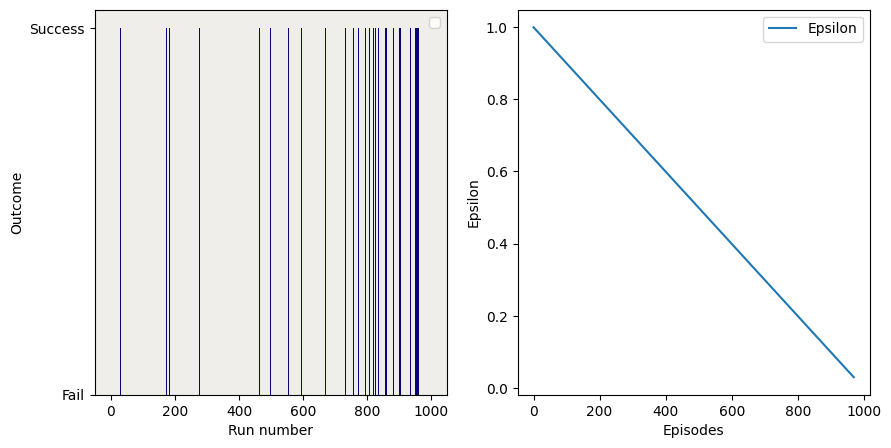

<Figure size 640x480 with 0 Axes>

In [84]:
episodes = 1000
rewards_per_episode = np.zeros(episodes)
epsilon_values = []
steps = 0
outcomes = []

# Training loop
for episode in tqdm(range(episodes)):
    state = env.reset()[0]
    terminated = False
    truncated = False

    outcomes.append("Fail")

    while(not terminated and not truncated):
        random_number = np.random.rand()

        # Epsilon greedy policy
        if random_number < epsilon:
            action = env.action_space.sample()                                              # Random action
        else:
            with torch.no_grad():
                action = torch.argmax(policy_net_new(one_hot(state, num_states=states))).item()  # Best action according to the policy network

        # Take action
        next_state, reward, terminated, truncated, _ = env.step(action)

        # Saving into replay memory for experience relay
        memory.append((state, action, reward, next_state, terminated))

        # Update state
        state = next_state
        steps += 1

    if reward == 1:
        rewards_per_episode[episode] = 1

    if reward:
        outcomes[-1] = "Success"

    # Sample from replay memory
    if len(memory) > batch_size and np.sum(rewards_per_episode) > 0:
        batch = memory.sample(batch_size)
        optimize(batch, policy_net_new, target_net_new)

        # Decay epsilon
        epsilon = max(epsilon - epsilon_decay, 0)
        epsilon_values.append(epsilon)

        # Sync target network with policy network after every network_sync_rate steps
        if steps > network_sync_rate:
            target_net_new.load_state_dict(policy_net_new.state_dict())
            # Reset steps
            steps = 0
    
# Plotting the rewards
plt.figure(figsize=(10, 5))
sum_rewards = np.cumsum(rewards_per_episode)
plt.subplot(1, 2, 1)
plt.xlabel("Run number")
plt.ylabel("Outcome")
ax = plt.gca()
ax.set_facecolor('#efeeea')
plt.bar(range(len(outcomes)), outcomes, color="#0A047A", width=1.0)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epsilon_values, label='Epsilon')
plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.legend()
plt.show()
plt.savefig('frozen_lake.png')
 

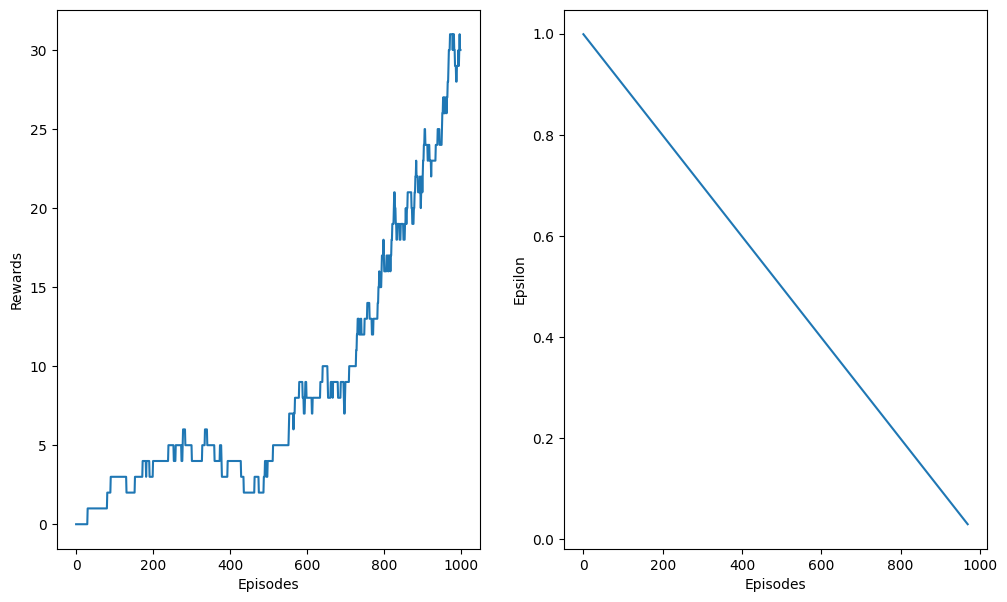

In [85]:
sum_rewards_train = np.zeros(episodes)
for x in range(episodes):
    sum_rewards_train[x] = np.sum(rewards_per_episode[max(0, x-100):(x+1)])

plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.plot(sum_rewards_train, label='Rewards')
plt.xlabel('Episodes')
plt.ylabel('Rewards')

plt.subplot(1, 2, 2)
plt.plot(epsilon_values, label='Epsilon')
plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.show()

In [86]:
# Testing the agent
test_episodes = 100
success = 0

policy_net.eval()

print("Policy (after training):", policy_net)

for episode in tqdm(range(test_episodes)):
    state = env.reset()[0]
    terminated = False
    truncated = False

    while(not terminated and not truncated):
        with torch.no_grad():
            action = torch.argmax(policy_net(one_hot(state, num_states=states))).item()

        # Take action
        next_state, reward, terminated, truncated, _ = env.step(action)

        state = next_state

    if reward == 1:
        success += 1

print(f"Success rate: {success/test_episodes*100}")

    

Policy (after training): DQN(
  (fc1): Linear(in_features=16, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=4, bias=True)
)


  0%|          | 0/100 [00:00<?, ?it/s]

Success rate: 3.0


In [87]:
print("Policy (after):")
print_net(policy_net)

Policy (after):
00, D, [+0.51 +0.59 +0.59 +0.55]01, R, [+0.55 +0.04 +0.65 +0.59]02, D, [+0.59 +0.73 +0.60 +0.66]03, L, [+0.65 +0.03 +0.45 +0.57]
04, D, [+0.58 +0.65 -0.00 +0.59]05, D, [+0.59 +0.73 +0.50 +0.43]06, D, [+0.10 +0.81 +0.10 +0.52]07, R, [+0.52 +0.70 +0.78 +0.52]
08, R, [+0.65 -0.01 +0.73 +0.61]09, D, [+0.68 +0.81 +0.80 +0.06]10, D, [+0.72 +0.90 -0.01 +0.62]11, U, [+0.42 +0.56 +0.49 +0.63]
12, L, [+0.55 +0.54 +0.49 +0.36]13, R, [+0.21 +0.82 +0.90 +0.73]14, R, [+0.79 +0.89 +1.00 +0.79]15, L, [+0.64 +0.59 +0.59 +0.54]


In [88]:
env.close()